# "Semantic Segmentation on Oxford-IIIT Pet Dataset"

> Semantic Segmentation with Amazon SageMaker
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/SemanticSegmentationWithAmazonSagemaker.png
- categories: [CV,   Semantic_Segmentation,   SageMaker,ResNet-50,FCN,Python]
- show_tags: true

## 1. Introduction
There are 4 prominent computer vision tasks:
1. Image Classification
2. Object Detection
3. Semantic Segmentation
4. Instance Segmentation

This post shows an example of *Semantic Segmentation*. We will use the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

The dataset consists of a 37 category dog and cat pet dataset with roughly 200 images for each class. The images have large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation. We will make use of the trimap segmentation pixel labels.

To perform the training and deployment of our semantic segmentation model we will make use of Amazon SageMaker. SageMaker provides a seamless pipeline.

## 2. Platform Setup
This notebook should be run on a 'notebook instance' which could be setup within the SageMaker service.

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

In [2]:
%matplotlib inline
import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
import boto3
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri

In [3]:
sagemaker.__version__

'2.32.0'

## 3. Get Data

In [4]:
#
# setup folders on the notebook instance/VM
if not os.path.isdir('data'):
    os.mkdir('data')

In [5]:
urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

In [6]:
def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
            print(f'{url} downloaded and extracted ...', )
        else:
            print('Already downloaded', url)

In [7]:
download_and_extract('data', '.')

http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz downloaded and extracted ...
http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz downloaded and extracted ...


In [8]:
# hide
!ls -lh

total 775M
-rw-rw-r-- 1 ec2-user ec2-user  19M Apr  8 13:31 annotations.tar.gz
drwxrwxr-x 4 ec2-user ec2-user 4.0K Apr  7 19:04 data
-rw-rw-r-- 1 ec2-user ec2-user 756M Apr  8 13:30 images.tar.gz
drwx------ 2 root     root      16K Apr  6 17:37 lost+found
-rw-rw-r-- 1 ec2-user ec2-user 571K Apr  7 20:30 Semantic Segmentation - Complete^1o.ipynb
-rw-rw-r-- 1 ec2-user ec2-user 529K Apr  8 13:31 SemanticSegmentation_Oxford-IIIT-Pet.ipynb


In [9]:
# 
# remove the tars
!rm *.tar.gz

In [10]:
# hide
!ls -lh

total 1.1M
drwxrwxr-x 4 ec2-user ec2-user 4.0K Apr  7 19:04 data
drwx------ 2 root     root      16K Apr  6 17:37 lost+found
-rw-rw-r-- 1 ec2-user ec2-user 571K Apr  7 20:30 Semantic Segmentation - Complete^1o.ipynb
-rw-rw-r-- 1 ec2-user ec2-user 529K Apr  8 13:31 SemanticSegmentation_Oxford-IIIT-Pet.ipynb


## 4. Inspect Data
We will use the following convention for naming data objects:
* x: train data
* y: label data
* yh: predicted data ('h' is for 'hat')

In [11]:
y_fold = 'data/annotations/trimaps/'
ys = [img for img in os.listdir(y_fold) if img[-3:] == 'png']
print(len(ys))

14780


In [12]:
x_fold = 'data/images/'
xs = [img for img in os.listdir(x_fold) if img[-3:] == 'jpg']
print(len(xs))

7390


In [13]:
xs[7]

'scottish_terrier_88.jpg'

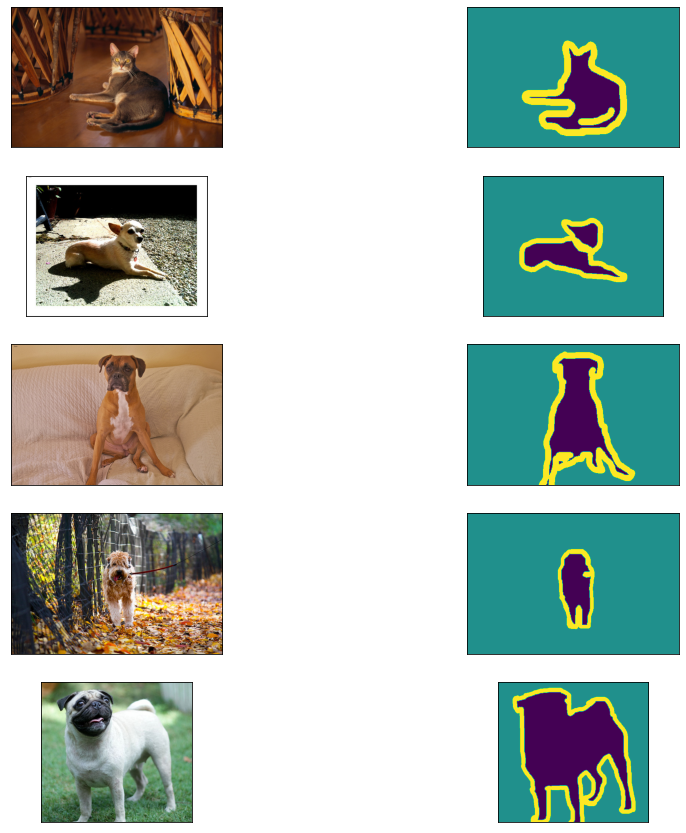

In [15]:
num_examples = 5
plt.figure(figsize=(15, 15))
for i in range(0, num_examples):
    ix = random.randint(0, len(xs) - 1)
    x_name = xs[ix]
    y_name = xs[ix].split('.')[0] + '.png'

    plt.subplot(num_examples, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(x_fold, x_name)))
    
    plt.subplot(num_examples, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(y_fold, y_name)))

In [17]:
ys[10]

'english_cocker_spaniel_173.png'

In [19]:
# 
# unique values in a label map
img = Image.open(os.path.join(y_fold, ys[10]))
print(np.unique(img))

[1 2 3]


## 5. Setup SageMaker

In [20]:
%%time
role = sagemaker.get_execution_role()
print(role)
ses = sagemaker.Session()

arn:aws:iam::005868863755:role/service-role/AmazonSageMaker-ExecutionRole-20210401T120740
CPU times: user 211 ms, sys: 25 ms, total: 236 ms
Wall time: 280 ms


In [21]:
buck = 'oxford-iiit-pet'
training_image = sagemaker.image_uris.retrieve( #docker image
    'semantic-segmentation', 
    ses.boto_region_name)
print(training_image)

433757028032.dkr.ecr.us-west-2.amazonaws.com/semantic-segmentation:1


## 6. Split Data into train/valid

In [22]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']
for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

In [23]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in ys
    return map_file

In [25]:
%%time
# split into train/valid
for image in tqdm(xs):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(y_fold, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:12<00:00, 598.10it/s] 

CPU times: user 2.45 s, sys: 1.61 s, total: 4.06 s
Wall time: 12.4 s


In [26]:
xs_trn = os.listdir('train')
ys_trn = os.listdir('train_annotation')

In [27]:
print(len(ys_trn), len(xs_trn))

5548 5548


## 7. Position Data on S3

In [28]:
buck

'oxford-iiit-pet'

In [29]:
%%time
ses = sagemaker.Session()

print('uploading data to S3 ...')
s3_xs_trn_path = ses.upload_data(path='train', bucket=buck, key_prefix='train')
print('xs_trn uploaded')
s3_ys_trn_path = ses.upload_data(path='train_annotation', bucket=buck, key_prefix='train_annotation')
print('ys_trn uploaded')
s3_xs_val_path = ses.upload_data(path='validation', bucket=buck, key_prefix='validation')
print('xs_val uploaded')
s3_ys_val_path = ses.upload_data(path='validation_annotation', bucket=buck, key_prefix='validation_annotation')
print('ys_val uploaded')

uploading data to S3 ...
xs_trn uploaded
ys_trn uploaded
xs_val uploaded
ys_val uploaded
CPU times: user 1min 43s, sys: 7.06 s, total: 1min 50s
Wall time: 13min 36s


In [38]:
# hide
# if data already on S3 (previous cell is NOT executed), run this cell:

# s3_xs_trn_path = 's3://oxford-iiit-pet/train/'
# s3_ys_trn_path = 's3://oxford-iiit-pet/train_annotation/'
# s3_xs_val_path = 's3://oxford-iiit-pet/validation/'
# s3_ys_val_path = 's3://oxford-iiit-pet/validation_annotation/'

In [30]:
s3_xs_trn_path

's3://oxford-iiit-pet/train'

In [31]:
s3_ys_trn_path

's3://oxford-iiit-pet/train_annotation'

In [32]:
# hide
# to list files in a folder:

# prefix = "train/"
# # prefix = "folderone/foldertwo/"
# s3 = boto3.resource('s3')
# bucket = s3.Bucket(name="yadav-petsdata")
# FilesNotFound = True
# for obj in bucket.objects.filter(Prefix=prefix):
#      print('{0}:{1}'.format(bucket.name, obj.key))
#      FilesNotFound = False
# if FilesNotFound:
#      print("ALERT", "No file in {0}/{1}".format(bucket, prefix))

## 8. SageMaker Model

In [34]:
model = sagemaker.estimator.Estimator(
    image_uri=training_image,
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    volume_size=100,
    max_run=36000,
    input_mode='File',
    #output_path='s3://oxford-iiit-pet/model-output', #.
    output_path=f's3://{buck}/model-output',
    sagemaker_session=ses
)

In [35]:
model.set_hyperparameters(
    backbone='resnet-50', #encoder
    algorithm='fcn', #decoder; other options'psp', 'deeplab'                             
    use_pretrained_model='True', #pre-trained on ImageNet
    crop_size=240, #size of image random crop
    num_classes=4,
    epochs=10, 
    learning_rate=0.0001,                             
    optimizer='rmsprop', #other options: 'adam', 'rmsprop', 'nag', 'adagrad'
    lr_scheduler='poly', #other options: 'cosine', step'.                           
    mini_batch_size=16, 
    validation_mini_batch_size=16,
    early_stopping=True, 
    early_stopping_patience=3, 
    early_stopping_min_epochs=10, 
    num_training_samples=len(xs_trn)
)

## 9. Train Model

In [36]:
distribution = 'FullyReplicated'
data_channels = {
    'train': sagemaker.inputs.TrainingInput(s3_xs_trn_path, distribution=distribution),
    'validation': sagemaker.inputs.TrainingInput(s3_xs_val_path, distribution=distribution),
    'train_annotation': sagemaker.inputs.TrainingInput(s3_ys_trn_path, distribution=distribution),
    'validation_annotation':sagemaker.inputs.TrainingInput(s3_ys_val_path, distribution=distribution),
}

In [37]:
data_channels

{'train': <sagemaker.inputs.TrainingInput at 0x7f62ca0996a0>,
 'validation': <sagemaker.inputs.TrainingInput at 0x7f62ca099710>,
 'train_annotation': <sagemaker.inputs.TrainingInput at 0x7f62ca099748>,
 'validation_annotation': <sagemaker.inputs.TrainingInput at 0x7f62ca099860>}

In [38]:
%%time
model.fit(inputs=data_channels, logs=True)

2021-04-08 14:05:21 Starting - Starting the training job...
2021-04-08 14:05:44 Starting - Launching requested ML instancesProfilerReport-1617890720: InProgress
......
2021-04-08 14:06:44 Starting - Preparing the instances for training......
2021-04-08 14:07:44 Downloading - Downloading input data...............
2021-04-08 14:10:14 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
[04/08/2021 14:10:20 INFO 140384837293888] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'backbone': 'resnet-50', 'algorithm': 'fcn', 'use_pretrained_model': 'True', 'crop_size': '240', 'epochs': '10', 'learning_rate': '0.001', 'optimizer': 'sgd', 'lr_scheduler': 'poly', 'lr_scheduler_factor': '0.1', 'weight_decay': '0.0001', 'momentum': '0.9', 'gamma1': '0.9', 'gamma2': '0.9', 'mini_batch

## 10. Deploy Model

In [61]:
%%time
model_deployed = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nmodel deployed ...')

-----------------!
model deployed ...
CPU times: user 314 ms, sys: 5.7 ms, total: 320 ms
Wall time: 8min 32s


## 11. Predict with Validation Data

In [62]:
x_fold = 'validation'
xs = [img for img in os.listdir(x_fold) if img[-3:] == 'jpg']
print(len(xs))

1842


In [63]:
y_fold = 'validation_annotation'
ys = [img for img in os.listdir(y_fold) if img[-3:] == 'png']
print(len(ys))

1842


In [64]:
model_deployed.serializer = sagemaker.serializers.IdentitySerializer('image/jpeg')
model_deployed.deserializer = sagemaker.deserializers.BytesDeserializer(accept='image/png')

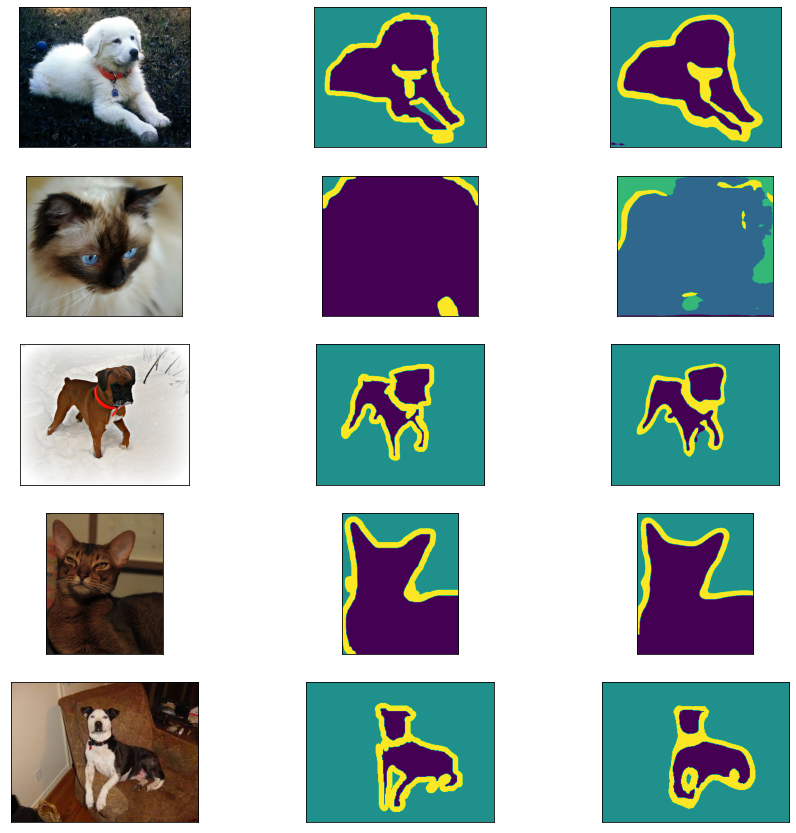

In [71]:
num_examples = 5
plt.figure(figsize=(15, 15))
for i in range(0, num_examples):
    ix = random.randint(0, len(xs) - 1)
    x_name = xs[ix]
    y_name = xs[ix].split('.')[0] + '.png'

    plt.subplot(num_examples, 3, 1 + i*3)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(x_fold, x_name)))
    
    plt.subplot(num_examples, 3, 2 + i*3)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(y_fold, y_name)))
    
    plt.subplot(num_examples, 3, 3 + i*3)
    plt.xticks([])
    plt.yticks([])
    x_path = os.path.join(x_fold, x_name)
    with open(x_path, 'rb') as f:
        b = bytearray(f.read())
    results = model_deployed.predict(b)
    yh = np.array(Image.open(io.BytesIO(results)))
    plt.imshow(yh);

In the above graphic:

Column 1: Input image (x)

Column 2: Label map (y)

Column 3: Predicted segmentation (yh)

## 12. Cleanup

In [72]:
# do this else you continue to accrue costs!
model_deployed.delete_endpoint()